Part 1: Dataset Loading & Exploration

In [1]:
import pandas as pd

df = pd.read_csv("digital_diet_mental_health.csv")

print("Dataset shape:", df.shape)
print(df.dtypes)
print(df.head())

print(df.isnull().sum())

Dataset shape: (2000, 25)
user_id                              object
age                                   int64
gender                               object
daily_screen_time_hours             float64
phone_usage_hours                   float64
laptop_usage_hours                  float64
tablet_usage_hours                  float64
tv_usage_hours                      float64
social_media_hours                  float64
work_related_hours                  float64
entertainment_hours                 float64
gaming_hours                        float64
sleep_duration_hours                float64
sleep_quality                         int64
mood_rating                           int64
stress_level                          int64
physical_activity_hours_per_week    float64
location_type                        object
mental_health_score                   int64
uses_wellness_apps                    int64
eats_healthy                          int64
caffeine_intake_mg_per_day          float64
weekly

Part 2: Preprocessing & Feature Selection

In [2]:
# Part 2: Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Select features
classification_features = ["daily_screen_time_hours", "sleep_duration_hours", "stress_level", "sleep_quality"]
clustering_features = ["social_media_hours", "gaming_hours", "entertainment_hours", "work_related_hours"]
regression_features = ["daily_screen_time_hours", "sleep_duration_hours", "stress_level"]

# Target columns
classification_target = "mental_health_score"
regression_target = "mood_rating"

# Impute numeric columns (median)
num_imputer = SimpleImputer(strategy="median")
df[classification_features] = num_imputer.fit_transform(df[classification_features])
df[clustering_features] = num_imputer.fit_transform(df[clustering_features])
df[regression_features] = num_imputer.fit_transform(df[regression_features])

# Encode sleep_quality if necessary (assuming numeric scale, skip if already numeric)
# If categorical (Poor/Okay/Good):
# le_sleep = LabelEncoder()
# df['sleep_quality'] = le_sleep.fit_transform(df['sleep_quality'])

# Create risk level for classification
def categorize_risk(score):
    if score <= 33:
        return "Low"
    elif score <= 66:
        return "Medium"
    else:
        return "High"

df['risk_level'] = df[classification_target].apply(categorize_risk)

# Scale numeric features
scaler_clf = StandardScaler()
X_clf = scaler_clf.fit_transform(df[classification_features])

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df[clustering_features])

scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(df[regression_features])

y_clf = df['risk_level']
y_reg = df[regression_target]


Part 3: Model Training

3a: Classification

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        High       0.19      0.09      0.12        88
         Low       0.16      0.08      0.10        93
      Medium       0.54      0.77      0.64       219

    accuracy                           0.46       400
   macro avg       0.30      0.31      0.29       400
weighted avg       0.37      0.46      0.40       400



3b: Clustering

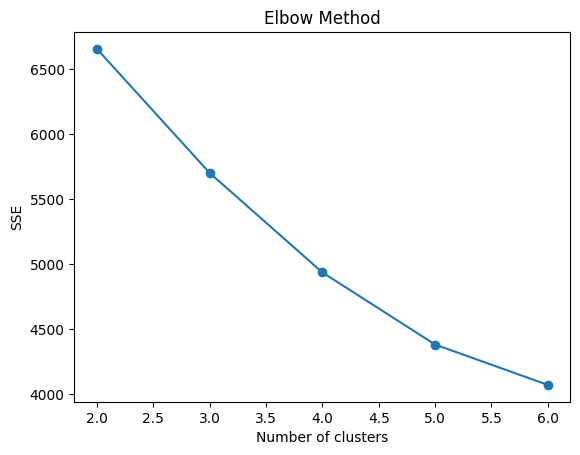

Silhouette Score: 0.17344277340466657


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow method to choose k
sse = []
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster)
    sse.append(km.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(2,7), sse, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# Train KMeans (assume k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)
df['cluster_id'] = cluster_labels

# Silhouette Score
score = silhouette_score(X_cluster, cluster_labels)
print("Silhouette Score:", score)


3c: Regression

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train Random Forest Regressor
reg = RandomForestRegressor(n_estimators=200, random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict & evaluate
y_pred_reg = reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("Regression MAE:", mae)
print("Regression RMSE:", rmse)


Regression MAE: 2.5673366071428574
Regression RMSE: 3.068377309652083


1️⃣ Improve Classification (Risk Prediction)

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Updated features
classification_features_updated = ["daily_screen_time_hours", "sleep_duration_hours", 
                                   "stress_level", "sleep_quality",
                                   "weekly_anxiety_score", "weekly_depression_score", 
                                   "physical_activity_hours_per_week"]

# Impute missing values
df[classification_features_updated] = SimpleImputer(strategy="median").fit_transform(df[classification_features_updated])

# Prepare X and y
X = df[classification_features_updated]
y = df['risk_level']

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train Gradient Boosting
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.62      0.44      0.52       230
         Low       0.55      0.53      0.54       205
      Medium       0.57      0.77      0.66       222

    accuracy                           0.58       657
   macro avg       0.58      0.58      0.57       657
weighted avg       0.58      0.58      0.57       657



2️⃣ Improve Clustering (Addiction Segments)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Add ratios
df['social_ratio'] = df['social_media_hours'] / (df['daily_screen_time_hours']+0.1)
df['gaming_ratio'] = df['gaming_hours'] / (df['daily_screen_time_hours']+0.1)

clustering_features_updated = ["social_ratio", "gaming_ratio", "entertainment_hours", "work_related_hours"]

# Scale
X_cluster = StandardScaler().fit_transform(df[clustering_features_updated])

# KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)
df['cluster_id'] = cluster_labels

# Silhouette
score = silhouette_score(X_cluster, cluster_labels)
print("Silhouette Score:", score)


Silhouette Score: 0.9303465152526452


3️⃣ Improve Regression (Mood Prediction)

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Updated features
regression_features_updated = ["daily_screen_time_hours", "sleep_duration_hours", "stress_level",
                               "caffeine_intake_mg_per_day", "physical_activity_hours_per_week",
                               "mindfulness_minutes_per_day"]

# Impute missing
df[regression_features_updated] = SimpleImputer(strategy="median").fit_transform(df[regression_features_updated])

X_reg = df[regression_features_updated]
y_reg = df['mood_rating']

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor
reg = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict & evaluate
y_pred_reg = reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("Regression MAE:", mae)
print("Regression RMSE:", rmse)


Regression MAE: 2.5933556075246624
Regression RMSE: 3.0373185323598806


In [9]:
import joblib

# Save models
joblib.dump(clf, "risk_model.pkl")
joblib.dump(scaler_clf, "scaler_clf.pkl")

joblib.dump(kmeans, "cluster_model.pkl")
joblib.dump(scaler_cluster, "scaler_cluster.pkl")

joblib.dump(reg, "mood_model.pkl")
joblib.dump(scaler_reg, "scaler_reg.pkl")


['scaler_reg.pkl']

In [15]:
from sklearn.preprocessing import StandardScaler
import joblib

# Features used for the final classification model (risk_model.pkl)
clf_features_updated = ["daily_screen_time_hours", "sleep_duration_hours", "stress_level",
                        "sleep_quality", "weekly_anxiety_score", "weekly_depression_score",
                        "physical_activity_hours_per_week"]

# Fit the scaler on the updated features from the original DataFrame (df)
scaler_clf = StandardScaler()
# Note: You need the original 'df' DataFrame defined in Cell 1 and modified in Cell 6 to be available
# Assuming df still holds all the data after initial preprocessing and imputation:
# If df is not available, you would need to reload and preprocess the original data up to Cell 6.
try:
    # Ensure df is available and all columns are present/imputed
    scaler_clf.fit(df[clf_features_updated])
    joblib.dump(scaler_clf, "scaler_clf.pkl")
    print("Successfully re-fitted and saved 'scaler_clf.pkl' with 7 features.")
except NameError:
    print("Error: DataFrame 'df' is not defined. You must run all previous notebook cells (1 through 8) first.")
except KeyError as e:
    print(f"Error: Missing feature in df: {e}. Check imputation steps.")


Successfully re-fitted and saved 'scaler_clf.pkl' with 7 features.


In [13]:
from sklearn.preprocessing import StandardScaler
import joblib

# Compute ratios
df['social_ratio'] = df['social_media_hours'] / (df['daily_screen_time_hours'] + 0.1)
df['gaming_ratio'] = df['gaming_hours'] / (df['daily_screen_time_hours'] + 0.1)

cluster_features_updated = ["social_ratio", "gaming_ratio", "entertainment_hours", "work_related_hours"]

scaler_cluster = StandardScaler()
scaler_cluster.fit(df[cluster_features_updated])
joblib.dump(scaler_cluster, "scaler_cluster.pkl")


['scaler_cluster.pkl']

TEST

In [11]:
import joblib

scaler_clf = joblib.load("scaler_clf.pkl")
print("Scaler features:", scaler_clf.feature_names_in_)
print("Number of features scaler expects:", len(scaler_clf.feature_names_in_))

scaler_cluster = joblib.load("scaler_cluster.pkl")
print(scaler_cluster.feature_names_in_)

scaler_reg = joblib.load("scaler_reg.pkl")
print(scaler_reg.feature_names_in_)

classification_model = joblib.load("risk_model.pkl")
print("Number of input features expected by classifier:", classification_model.n_features_in_)

regression_model = joblib.load("mood_model.pkl")
print("Number of input features expected by regressor:", regression_model.n_features_in_)

# Example for classifier scaler
expected = set(scaler_clf.feature_names_in_)
given = set(sample_user.columns)

missing = expected - given
extra = given - expected

print("Missing features:", missing)
print("Extra features:", extra)



Scaler features: ['daily_screen_time_hours' 'sleep_duration_hours' 'stress_level'
 'sleep_quality']
Number of features scaler expects: 4
['social_media_hours' 'gaming_hours' 'entertainment_hours'
 'work_related_hours']
['daily_screen_time_hours' 'sleep_duration_hours' 'stress_level']
Number of input features expected by classifier: 7
Number of input features expected by regressor: 6
Missing features: set()
Extra features: {'entertainment_hours', 'gaming_hours', 'work_related_hours', 'weekly_depression_score', 'weekly_anxiety_score', 'physical_activity_hours_per_week', 'social_media_hours'}
